In [158]:
from pandas import read_csv, DataFrame, concat
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
locationGameFile=pathlib.Path("C:\\Users\\z004cnpx\\Desktop\\steam-games.csv")
dataGames = read_csv(locationGameFile, usecols=["name", "genre", "game_details", "popular_tags"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


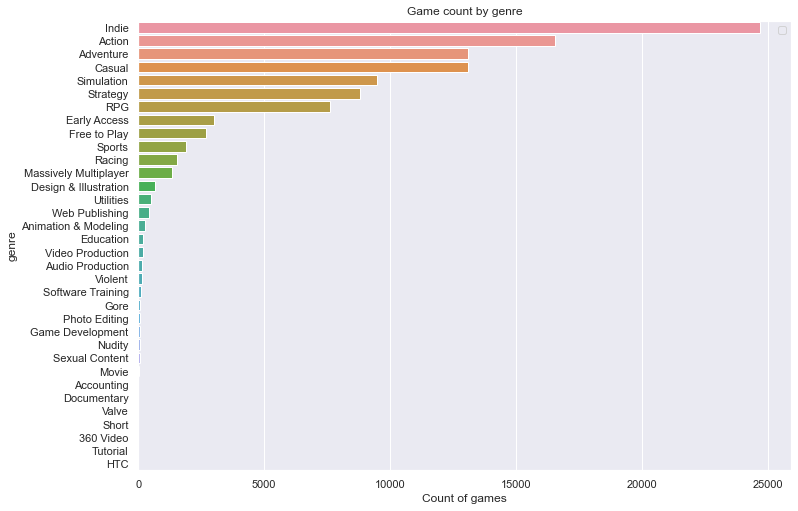

In [142]:
## Genre plot
x = []

for i, row in dataGames.iterrows():
    if type(row["genre"]) is str:
        x = x + row["genre"].split(',')

uniqueGenre = list(set(x))

df = DataFrame(columns=["genre", "count"])
for genre in uniqueGenre:
    df2 = DataFrame(data=[[genre, x.count(genre)]], columns=["genre", "count"])
    df = concat([df, df2], ignore_index=True)

df = df.sort_values(by="count", ascending=False)

sns.set(rc={'figure.figsize':(11.7,8.27)})

plott = sns.barplot(y = 'genre', x = 'count', data = df) 
plott.set(xlabel='Number of games', ylabel='genre', title='Game count by genre')
plott.legend(fontsize=10)
plt.show()

) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\z004cnpx\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


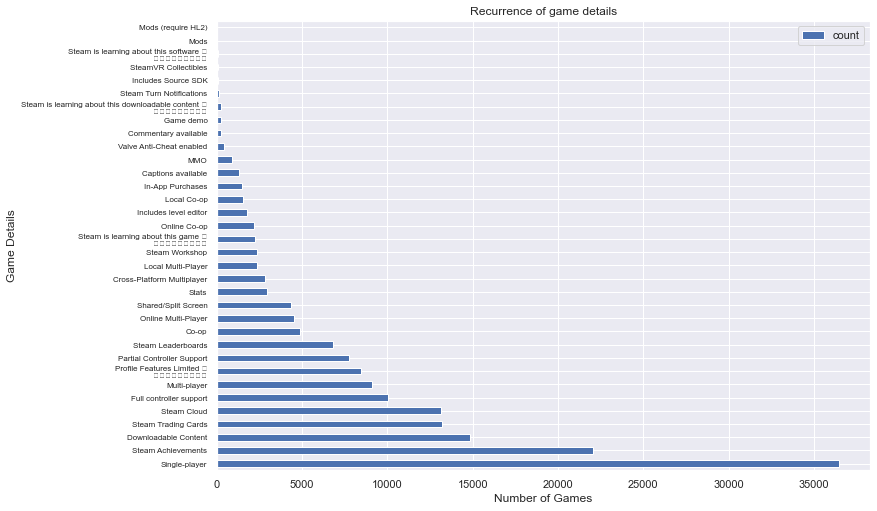

In [150]:
##  game details
x = []

for i, row in dataGames.iterrows():
    if type(row["game_details"]) is str:
        x = x + row["game_details"].split(',')

uniqueGenre = list(set(x))

df = DataFrame(columns=["game_details", "count"])
for genre in uniqueGenre:
    df2 = DataFrame(data=[[genre, x.count(genre)]], columns=["game_details", "count"])
    df = concat([df, df2], ignore_index=True)

df = df.sort_values(by="count", ascending=False)

ax = df.plot.barh(x='game_details', y='count')

# Add title and axis names
plt.title('Recurrence of game details')
plt.xlabel('Number of Games')
plt.ylabel('Game Details')
plt.yticks(fontsize=8)

plt.show()

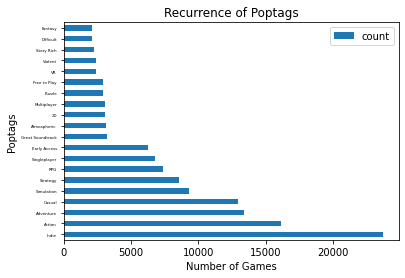

In [162]:
## analyze for popular tags
x = []

for i, row in dataGames.iterrows():
    if type(row["popular_tags"]) is str:
        x = x + row["popular_tags"].split(',')

uniquePopTags = list(set(x))

df = DataFrame(columns=["popular_tags", "count"])
for poptags in uniquePopTags:
    df2 = DataFrame(data=[[poptags, x.count(poptags)]], columns=["popular_tags", "count"])
    df = concat([df, df2], ignore_index=True)

df = df.sort_values(by="count", ascending=False)
df = df.head(20)
df.plot.barh(x='popular_tags', y='count')

# Add title and axis names
plt.title('Recurrence of Poptags')
plt.xlabel('Number of Games')
plt.ylabel('Poptags')
plt.yticks(fontsize=4)

plt.show()

In [163]:
## get user data (raw)
locationUsersFile=pathlib.Path("C:\\Users\\z004cnpx\\Desktop\\steam-user-game-train.csv")
dataUsers = read_csv(locationUsersFile)
dataUsers

,UserID,Game,Action,Hours
0,151603712.0,The Elder Scrolls V Skyrim,play,273.0
1,151603712.0,Fallout 4,play,87.0
2,151603712.0,Spore,play,14.9
3,151603712.0,Fallout New Vegas,play,12.1
4,151603712.0,HuniePop,play,8.5
...,...,...,...,...
56377,128470551.0,Fallen Earth,play,2.4
56378,128470551.0,Magic Duels,play,2.2
56379,128470551.0,Titan Souls,play,1.5
56380,128470551.0,Grand Theft Auto Vice City,play,1.5


In [164]:
dataGames['name'] = dataGames['name'].fillna('')
dataUsers['UserID'] = dataUsers['UserID'].astype(int)
# create column ID for game and user dataset
dataGames["ID"] = ""
dataUsers["ID"] = ""

In [165]:
# space and special char removal
import re
for i, row in dataGames.iterrows():
    name = re.sub('[^A-Za-z0-9]+', '', row["name"])
    name = name.lower()
    dataGames.at[i, 'ID'] = name

for i, row in dataUsers.iterrows():
    name = re.sub('[^A-Za-z0-9]+', '', row["Game"])
    name = name.lower()
    dataUsers.at[i, 'ID'] = name

In [166]:
# find all the games in the game dataset that match the games in user dataset
gamesInUserSet = dataUsers["ID"].unique()
print("Unique games in user set: ", len(gamesInUserSet))
intersection = dataGames['ID'].isin(gamesInUserSet)
usedGames = dataGames[intersection]
print("Games in common: ", len(usedGames))

Unique games in user set:  3357
Games in common:  2164


In [167]:
# relevant info for recommendation: genre game_details popular_tags publisher developer
features = ['genre', 'game_details', 'popular_tags']
for feature in features:
    usedGames.loc[:, feature] = usedGames[feature].fillna('')
# the other columns, they do not have good relevance with respect to users.

C:\Users\z004cnpx\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [168]:
usedGames.to_csv(pathlib.Path("C:\\Users\\z004cnpx\\Desktop\\steam-games-processed.csv"), index=False)
len(usedGames)

2164

In [169]:
## get usedGames!!
locationGamesFile = pathlib.Path("C:\\Users\\z004cnpx\\Desktop\\steam-games-processed.csv")
usedGames = read_csv(locationGamesFile)

In [170]:
from pandas import Series, concat
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Construct a reverse map of indices and game names
usedGames.drop_duplicates(subset=['name'],keep='last')
# get list of games we have info about
listGames = usedGames['name'].unique()

In [171]:
#Number of recommendation
n_recommendation = 10
# create dataframe for recommendations
col_names = list(map(str, range(1, n_recommendation + 1)))
col_names = ["UserID"] + col_names

In [172]:
#combine features to a single feature
def combined_features(row):
    return str(row['genre'])+" "+str(row['game_details'])+" "+str(row['popular_tags'])

usedGames['combined_features'] = usedGames.apply(combined_features,axis = 1)
usedGames.head(3)

,name,popular_tags,game_details,genre,ID,combined_features
0,DayZ,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","Action,Adventure,Massively Multiplayer",dayz,"Action,Adventure,Massively Multiplayer Multi-p..."
1,EVE Online,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","Action,Free to Play,Massively Multiplayer,RPG,...",eveonline,"Action,Free to Play,Massively Multiplayer,RPG,..."
2,TERA,"Free to Play,MMORPG,Massively Multiplayer,RPG,...","Multi-player,MMO,Co-op,Steam Trading Cards,Par...","Action,Adventure,Free to Play,Massively Multip...",tera,"Action,Adventure,Free to Play,Massively Multip..."


In [173]:
#sklearn.feature_extraction module can be used to extract features in format supported by machine learning algorithms
#in that module, CountVectorizer count the number of text
cv = CountVectorizer()
count_matrix = cv.fit_transform(usedGames['combined_features'])
print("Count Matrix: ",count_matrix.toarray())

Count Matrix:  [[0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [174]:
#cosine sim matrix
cosine_sim = cosine_similarity(count_matrix)

In [175]:
usedGames['index'] = usedGames.index
usedGames.head(3)

,name,popular_tags,game_details,genre,ID,combined_features,index
0,DayZ,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Multi-player,Online Multi-Player,Steam Worksho...","Action,Adventure,Massively Multiplayer",dayz,"Action,Adventure,Massively Multiplayer Multi-p...",0
1,EVE Online,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Multi-player,Online Multi-Player,MMO,Co-op,Onl...","Action,Free to Play,Massively Multiplayer,RPG,...",eveonline,"Action,Free to Play,Massively Multiplayer,RPG,...",1
2,TERA,"Free to Play,MMORPG,Massively Multiplayer,RPG,...","Multi-player,MMO,Co-op,Steam Trading Cards,Par...","Action,Adventure,Free to Play,Massively Multip...",tera,"Action,Adventure,Free to Play,Massively Multip...",2


In [176]:
## recommendation for a game ****TEST**** check
game_user_like = "Dota 2"

def get_index_from(game):
    return usedGames[usedGames.name == game]['index'].values[0]

game_index = get_index_from(game_user_like)
game_index

116

In [177]:
# recommend similar games without considering user
similar_games = list(enumerate(cosine_sim[game_index]))
sorted_similar_games = sorted(similar_games, key = lambda x:x[1], reverse = True)
def get_title_from_index(index):
    return usedGames[usedGames.index == index]["name"].values[0]

i=0
for games in sorted_similar_games:
    print(get_title_from_index(games[0]))
    i = i+1;
    if i>10:
        break

Dota 2
Prime World
Counter-Strike: Global Offensive
Dungeon Defenders II
RIFT
AirBuccaneers
Warface
Star Trek Online
Path of Exile
SMITE®
Kingdom Wars


In [178]:
# Function that takes in game name and Cosine Similarity matrix as input and outputs most similar games
def get_recommendations(title, cosine_sim):
    if title not in listGames:
        return []
    # Get the index of the game
    idx = usedGames[usedGames.name == title]['index'].values[0]
    # if idx become an array
    if type(idx) is Series:
        return []
    # Get the pairwise similarity scores of all games with that game
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the most similar games
    # (not the first one because this games as a score of 1 (perfect score) similarity with itself)
    sim_scores = sim_scores[1:n_recommendation + 1]
    # Get the games indices
    game_indices = [i[0] for i in sim_scores]
    # Return the top most similar games
    return usedGames['name'].iloc[game_indices].tolist()

In [179]:
def make_recommendation_for_user(user_id, suggestion_list, game_user_have):
    if type(suggestion_list) is not list or len(suggestion_list) == 0:
        # return empty one
        return DataFrame(data=[[user_id] + [""] * n_recommendation], columns=col_names)

    # get reviews of game recommendation, remove the games the user already has and order them by reviews
    recommendation = usedGames.loc[usedGames['name'].isin(suggestion_list)]
    recommendation = recommendation.loc[~recommendation['name'].isin(game_user_have)]
    recommendation = recommendation.sort_values(by="combined_features", ascending=False)

    if len(recommendation.index) < n_recommendation:
        return DataFrame(data=[[user_id] + recommendation["name"].tolist() +
                               [""] * (n_recommendation - len(recommendation.index))],
                         columns=col_names)
    else:
        return DataFrame(data=[[user_id] + recommendation["name"].tolist()[0:n_recommendation]],
                         columns=col_names)


In [ ]:
output_file= pathlib.Path("C:\\Users\\z004cnpx\\Desktop\\content_based_recommender_combined_features.csv")
recommendationByUserData = DataFrame(columns=col_names)
previousId = ""
listSuggestion = list()
listGamesUserHas = list()

# loop on all row and get recommendations for user
for j, row in dataUsers.iterrows():
    if previousId != row["UserID"]:
        recommendationByUserData = concat([recommendationByUserData,
                                           make_recommendation_for_user(previousId, listSuggestion, listGamesUserHas)],
                                          ignore_index=True)
        previousId = row["UserID"]
        listSuggestion = list()
        listGamesUserHas = list()
    # add all elements to list
    listGamesUserHas.extend([row["Game"]])
    listSuggestion.extend(get_recommendations(row["Game"], cosine_sim))

# add the last element for the last user
recommendationByUserData = concat([recommendationByUserData,
                                   make_recommendation_for_user(previousId, listSuggestion, listGamesUserHas)],
                                  ignore_index=True)
recommendationByUserData.to_csv(output_file, index=False)

In [ ]:
locationUserFile=pathlib.Path("C:\\Users\\z004cnpx\\Desktop\\steam-user-game-test.csv")
dataUsersTest = read_csv(locationUserFile, skiprows = 1,header = None, usecols=[0, 1], names=['UserID', 'Game'])
dataUsersTest

In [ ]:
dataUsersTestDict = dict()
for k, v in dataUsersTest.groupby('UserID'):
    dataUsersTestDict[k] = v
    

In [ ]:
#### TEST #####
dataUsersTestDict[5250].Game.tolist()

In [ ]:
#### TEST #####
recommendationByUserData.loc[recommendationByUserData['UserID'] == 5250, str(10)].iloc[0]

In [ ]:
#### TEST #####
recommendationByUserData.loc[recommendationByUserData['UserID'] == 5250].empty

In [ ]:
#### TEST #####
## example common_elements for a user..
tempGamesRecommendedList = list()
tempGamesDictList = list()

tempGamesDictList = dataUsersTestDict[12144171].Game.tolist()
# bu key(UserID)in recommendationByUserDatadaki row unu bul.
for i in range(1,10):
    tempGamesRecommendedList.append(recommendationByUserData.loc[recommendationByUserData['UserID'] == 12144171, str(i)].iloc[0])
#print(intersection(tempGamesDictList, tempGamesRecommendedList))
common_elements = list(set(tempGamesDictList).intersection(set(tempGamesRecommendedList)))
common_elements

In [ ]:
##  ACCURACY CALCULATION after combined_features
tempGamesDictList = list()
common_counter = 0
# foreach key in df_games , you get values (games)
for userId in dataUsersTestDict:
    #print("usernext", userId)
    tempGamesDictList = dataUsersTestDict[userId].Game.tolist()
    # By this key(UserID), find the row in recommendationByUserData
    tempGamesRecommendedList = list()
    if not recommendationByUserData.loc[recommendationByUserData['UserID'] == userId].empty:
        #recommended DataFrame is provided for this user!
    
        for i in range(1,11):
            tempGamesRecommendedList.append(recommendationByUserData.loc[recommendationByUserData['UserID'] == userId, str(i)].iloc[0])
        #print("test", tempGamesDictList, "for user", userId)
        #print("recomm", tempGamesRecommendedList, "for userr", userId)

        common_elements = list(set(tempGamesDictList).intersection(set(tempGamesRecommendedList)))
        if(len(common_elements)>0):
            print(common_elements, "is the common element(s) for this userId:", userId)
            common_counter+=1

print("Exact game match rate:", common_counter/recommendationByUserData.shape[0]) 
